# EDA — Pitching-focused analysis

This notebook was auto-generated from `/mnt/data/pa_decisions_2022_2023.csv`. It focuses on pitching-related metrics requested: mean innings before pulled, number of pitches thrown, times through order, handedness percentages, pitch speeds, and pitch-type distributions. Visual assets have been saved to `/mnt/data/viz/`.

## Detected relevant columns

- **inning_cols**: inning, outs
- **pitches_cols**: pitcher_on_mound, pitcher_days_since_prev_game, pitcher_is_left, pitcher_is_right, pitch_count, next_pitcher_id
- **tto_cols**: tto
- **handedness_cols**: p_throws
- **speed_cols**: release_speed
- **pitch_type_cols**: pitch_number, pitcher_on_mound, pitcher_days_since_prev_game, pitcher_is_left, pitcher_is_right, pitch_count, next_pitcher_id
- **pitcher_id_cols**: pitcher_on_mound, pitcher_days_since_prev_game, pitcher_is_left, pitcher_is_right, next_pitcher_id
- **appearance_id_cols**: game_pk


## Data sample (first 5 rows)

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os

pd.options.display.max_columns = 200
df = pd.read_parquet('../data/processed/pa_decisions_2022_2023.parquet')

pd.set_option('display.max_rows', None)
print(df.columns.tolist())

df.head()

['game_pk', 'game_date', 'game_year', 'pitch_number', 'at_bat_number', 'batter', 'pitcher_on_mound', 'home_team', 'away_team', 'stand', 'p_throws', 'inning', 'inning_topbot', 'outs', 'balls', 'strikes', 'on_1b', 'on_2b', 'on_3b', 'bat_score', 'fld_score', 'bat_score_diff', 'home_score_diff', 'events', 'type', 'description', 'zone', 'bb_type', 'launch_speed', 'launch_angle', 'hit_distance_sc', 'woba_value', 'estimated_woba_using_speedangle', 'launch_speed_angle', 'delta_run_exp', 'release_speed', 'release_spin_rate', 'pitcher_days_since_prev_game', 'n_priorpa_thisgame_player_at_bat_x', 'half', 'base_state', 'batting_team', 'fielding_team', 'score_diff', 'batter_is_left', 'batter_is_right', 'batter_is_switch', 'pitcher_is_left', 'pitcher_is_right', 'is_platoon_advantage', 'pitch_count', 'n_priorpa_thisgame_player_at_bat_y', 'tto', 'lineup_idx', 'next_hitters_ids', 'time_index_pa', 'delta_re_pa', 'half_inning_over', 'game_over', 'reward_folded', 'next_state_idx', 'action_idx', 'next_pitch

,game_pk,game_date,game_year,pitch_number,at_bat_number,batter,pitcher_on_mound,home_team,away_team,stand,p_throws,inning,inning_topbot,outs,balls,strikes,on_1b,on_2b,on_3b,bat_score,fld_score,bat_score_diff,home_score_diff,events,type,description,zone,bb_type,launch_speed,launch_angle,hit_distance_sc,woba_value,estimated_woba_using_speedangle,launch_speed_angle,delta_run_exp,release_speed,release_spin_rate,pitcher_days_since_prev_game,n_priorpa_thisgame_player_at_bat_x,half,base_state,batting_team,fielding_team,score_diff,batter_is_left,batter_is_right,batter_is_switch,pitcher_is_left,pitcher_is_right,is_platoon_advantage,pitch_count,n_priorpa_thisgame_player_at_bat_y,tto,lineup_idx,next_hitters_ids,time_index_pa,delta_re_pa,half_inning_over,game_over,reward_folded,next_state_idx,action_idx,next_pitcher_id
0,661032,2022-04-26,2022,1,1,664702,663776,LAA,CLE,R,L,1,Top,0,0,0,<NA>,<NA>,<NA>,0,0,0,0,strikeout,B,ball,14,None,<NA>,<NA>,<NA>,0.0,0.0,<NA>,0.037,94.7,2105,7,0,0,0,CLE,LAA,0,0,1,0,1,0,1,1,0,0,0,"[642708, 608070, 614177, 680911, 640458]",1650931200000000011,-0.247,False,False,0.740466,2,0,-1
1,661032,2022-04-26,2022,1,2,642708,663776,LAA,CLE,R,L,1,Top,1,0,0,<NA>,<NA>,<NA>,0,0,0,0,field_out,S,called_strike,3,ground_ball,69.5,-30,3,0.0,0.062,2,-0.038,95.3,2207,7,0,0,0,CLE,LAA,0,0,1,0,1,0,1,5,0,0,1,"[608070, 614177, 680911, 640458, 676391]",1650931200000000015,-0.246,False,False,0.498450,2,0,-1
2,661032,2022-04-26,2022,1,3,608070,663776,LAA,CLE,R,L,1,Top,2,0,0,<NA>,<NA>,<NA>,0,0,0,0,field_out,S,swinging_strike,8,fly_ball,73.5,46,213,0.0,0.011,3,-0.043,84.0,2264,7,0,0,0,CLE,LAA,0,0,1,0,1,0,1,7,0,0,2,"[614177, 680911, 640458, 676391, 595978]",1650931200000000017,-0.255,True,False,0.255000,2,0,-1
3,661032,2022-04-26,2022,1,7,614177,663776,LAA,CLE,R,L,2,Top,0,0,0,<NA>,<NA>,<NA>,0,0,0,0,strikeout,S,swinging_strike,13,None,<NA>,<NA>,<NA>,0.0,0.0,<NA>,-0.038,81.9,2820,7,0,0,0,CLE,LAA,0,0,1,0,1,0,1,10,0,0,3,"[680911, 640458, 676391, 595978, 665926]",1650931200000000029,-0.246,False,False,0.740446,5,0,-1
4,661032,2022-04-26,2022,1,8,680911,663776,LAA,CLE,R,L,2,Top,1,0,0,<NA>,<NA>,<NA>,0,0,0,0,field_out,B,ball,11,fly_ball,86.3,43,289,0.0,0.014,3,0.036,81.7,2864,7,0,0,0,CLE,LAA,0,0,1,0,1,0,1,14,0,0,4,"[640458, 676391, 595978, 665926, 664702]",1650931200000000033,-0.246,False,False,0.499440,5,0,-1


## 1. Distribution of Innings Before Being Pulled

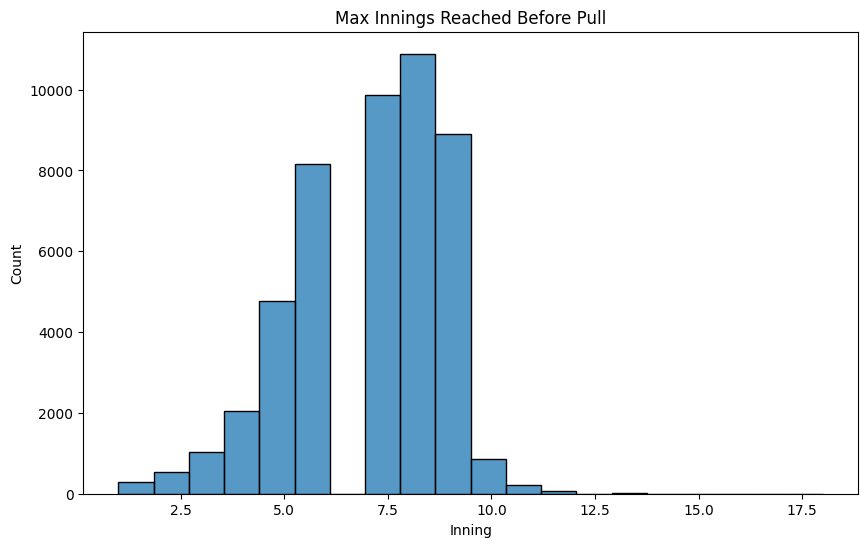

In [12]:
# ---- CREATE OUTPUT DIRECTORY ----
os.makedirs("viz", exist_ok=True)

# ---- CONFIGURE COLUMN NAMES ----
INNING_COL = "inning"
PITCH_COUNT_COL = "pitch_count"
TTO_COL = "tto"
HAND_COL = "p_throws"
PITCH_SPEED_COL = "release_speed"
PITCH_TYPE_COL = "type"         # pitch type label in your dataset

viz_folder = "viz"
os.makedirs(viz_folder, exist_ok=True)

# Calculate max inning per appearance
innings_per_game = (
    df.groupby(["pitcher_on_mound", "game_pk"])[INNING_COL]
    .max()
    .reset_index(name="max_inning")
)

plt.figure(figsize=(10,6))
sns.histplot(innings_per_game["max_inning"], bins=20)
plt.title("Max Innings Reached Before Pull")
plt.xlabel("Inning")
plt.ylabel("Count")

plt.savefig(f"{viz_folder}/innings_before_pull_hist.png", dpi=300)
plt.show()


## 2. Distribution of Total Pitches Thrown per Appearance

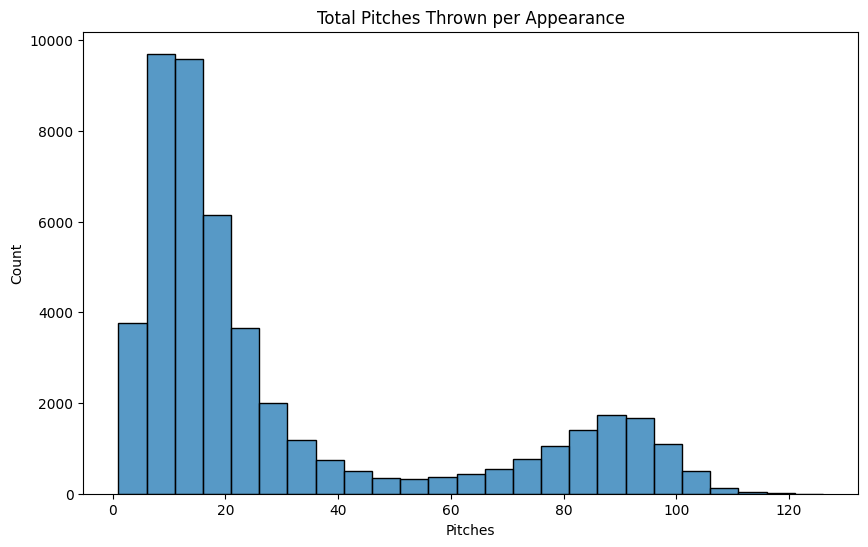

In [13]:
pitches_per_game = (
    df.groupby(["pitcher_on_mound", "game_pk"])[PITCH_COUNT_COL]
    .max()   # pitch_count column already cumulative
    .reset_index(name="total_pitches")
)

plt.figure(figsize=(10,6))
sns.histplot(pitches_per_game["total_pitches"], bins=25)
plt.title("Total Pitches Thrown per Appearance")
plt.xlabel("Pitches")
plt.ylabel("Count")

plt.savefig(f"{viz_folder}/pitches_per_game_hist.png", dpi=300)
plt.show()

## 3. Distribution of Times Through Order (TTO)

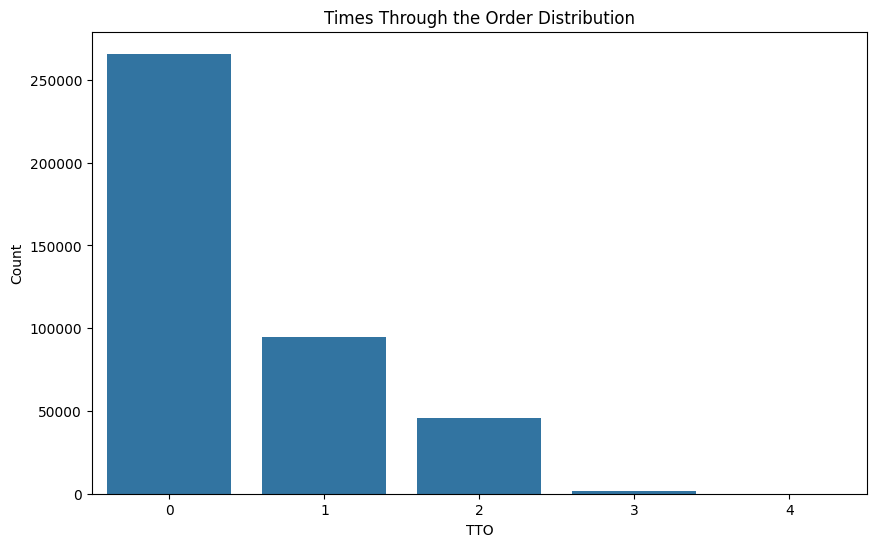

In [14]:
plt.figure(figsize=(10,6))
sns.countplot(x=df[TTO_COL])
plt.title("Times Through the Order Distribution")
plt.xlabel("TTO")
plt.ylabel("Count")

plt.savefig(f"{viz_folder}/tto_distribution.png", dpi=300)
plt.show()

## 4. Handedness Percentages (L/R/S)
Column: p_throws

Values typically: L, R

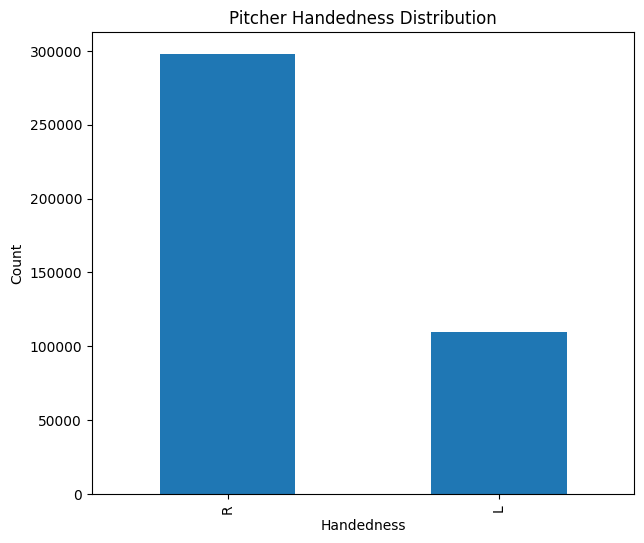

In [15]:
plt.figure(figsize=(7,6))
df[HAND_COL].value_counts().plot(kind="bar")
plt.title("Pitcher Handedness Distribution")
plt.xlabel("Handedness")
plt.ylabel("Count")

plt.savefig(f"{viz_folder}/handedness_distribution.png", dpi=300)
plt.show()

## 5. Pitch Speed Distribution
Column: release_speed

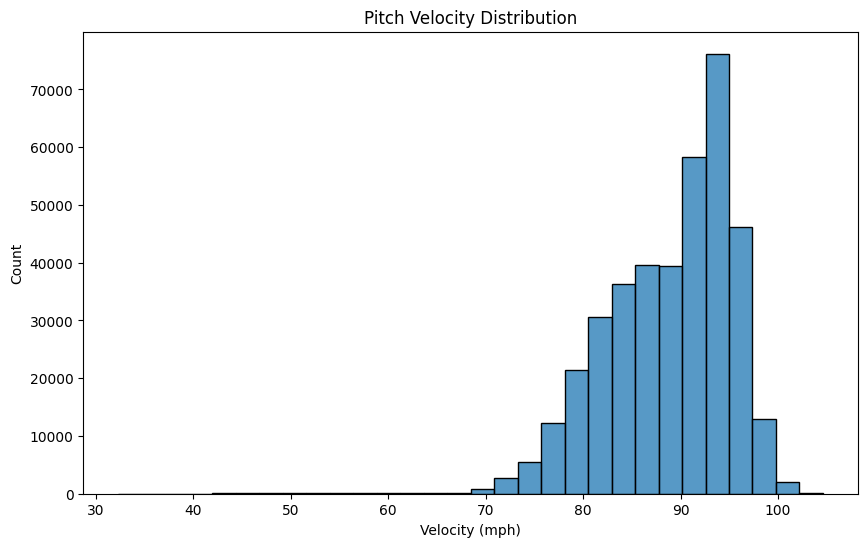

In [16]:
plt.figure(figsize=(10,6))
sns.histplot(df[PITCH_SPEED_COL].dropna(), bins=30)
plt.title("Pitch Velocity Distribution")
plt.xlabel("Velocity (mph)")
plt.ylabel("Count")

plt.savefig(f"{viz_folder}/pitch_velocity_hist.png", dpi=300)
plt.show()

## 6. Pitch Type Percentages
Column: type

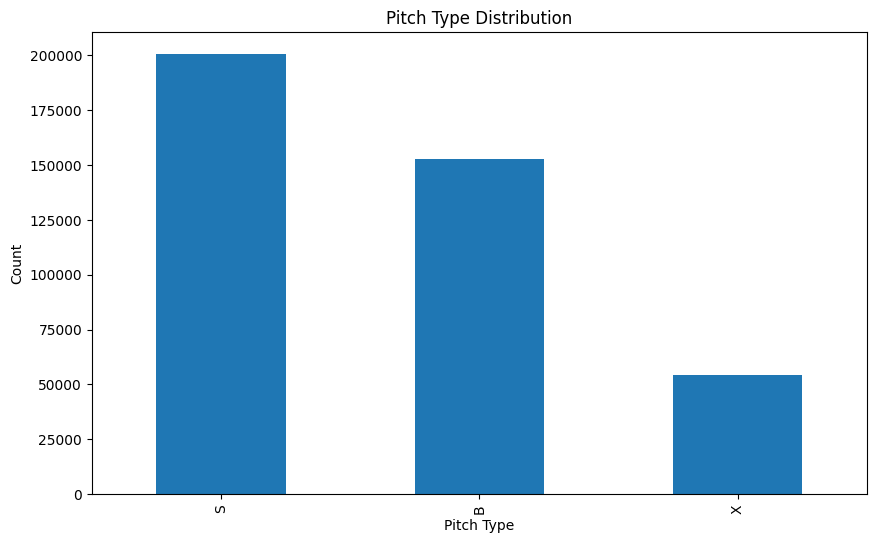

In [17]:
plt.figure(figsize=(10,6))
df[PITCH_TYPE_COL].value_counts().plot(kind="bar")
plt.title("Pitch Type Distribution")
plt.xlabel("Pitch Type")
plt.ylabel("Count")

plt.savefig(f"{viz_folder}/pitch_type_distribution.png", dpi=300)
plt.show()

## 7. Heatmap: Pitchers × Pitch Types Usage

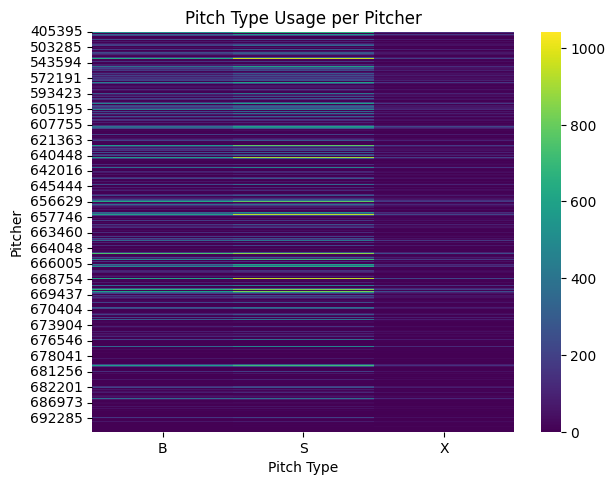

In [27]:
pivot = pd.crosstab(df["pitcher_on_mound"], df[PITCH_TYPE_COL])

rows, cols = pivot.shape
sns.heatmap(pivot, cmap="viridis")
plt.tight_layout()

plt.title("Pitch Type Usage per Pitcher")
plt.xlabel("Pitch Type")
plt.ylabel("Pitcher")

plt.savefig(f"{viz_folder}/pitcher_pitchtype_heatmap.png", dpi=300)
plt.show()

## 8. Correlation Heatmap for Numerical Features

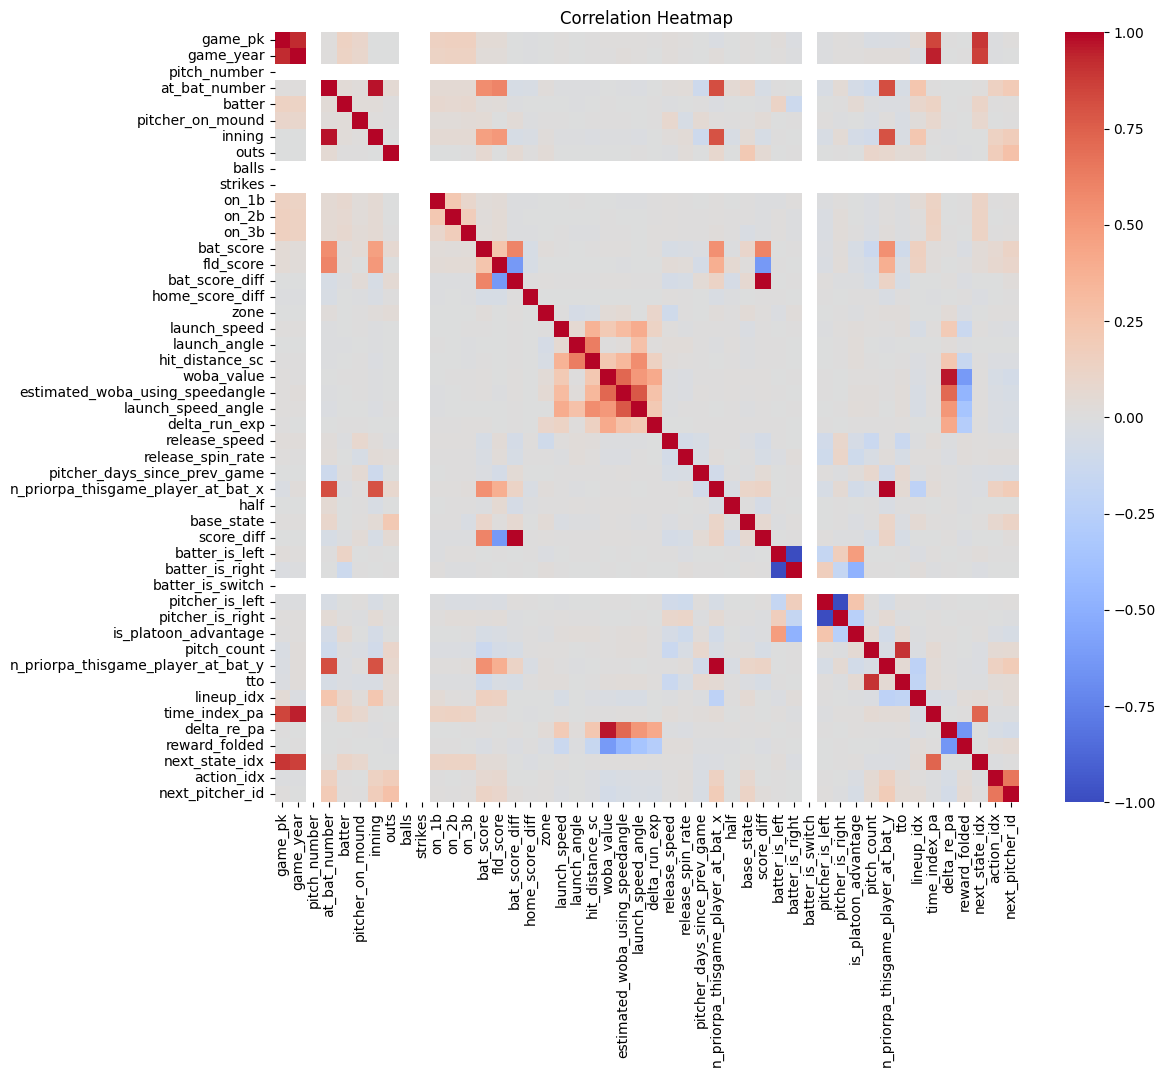

In [23]:
plt.figure(figsize=(12,10))
sns.heatmap(df.select_dtypes("number").corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.savefig(f"{viz_folder}/correlation_heatmap.png", dpi=300)
plt.show()